In [ ]:
import tensorflow as tf
import gc
import os
import numpy as np
import tensorflow_datasets as tfds

In [ ]:
resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='')
tf.config.experimental_connect_to_cluster(resolver)
# This is the TPU initialization code that has to be at the beginning.
tf.tpu.experimental.initialize_tpu_system(resolver)
print("All devices: ", tf.config.list_logical_devices('TPU'))

All devices:  [LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:0', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:1', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:2', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:3', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:4', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:5', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:6', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:7', device_type='TPU')]


In [ ]:
strategy = tf.distribute.TPUStrategy(resolver)

In [ ]:
!pip install hickle
import hickle as hkl
import os
import matplotlib.pyplot as plt
from keras import layers,Input,Sequential
from keras.layers import Dense,Flatten,Reshape,Conv2DTranspose,Conv2D,MaxPooling2D,Reshape,Resizing,Dropout,UpSampling2D
from tensorflow.keras import datasets, layers, models, losses, Model
from random import randint
import numpy as np
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential,Model
import matplotlib.pyplot as plt
from google.colab  import drive
drive.mount("/gdrive")
%cd /gdrive

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive


In [ ]:
with strategy.scope():
    load_locally = tf.saved_model.LoadOptions(experimental_io_device='/job:localhost')
    reconstructed_front =   tf.keras.models.load_model('/gdrive/My Drive/Model_run_v2/Frontal', options=load_locally)
    reconstructed_right =   tf.keras.models.load_model('/gdrive/My Drive/Model_run_v2/Right', options=load_locally)
    reconstructed_right45 = tf.keras.models.load_model('/gdrive/My Drive/Model_run_v2/Right45', options=load_locally)

In [ ]:
load_hkl = hkl.load("/gdrive/My Drive/Yedek/Autoencoder_Datasets_filtered_v2/Static/Frontal.hkl")
X_train_frontal=load_hkl['xtrain'] / 255.
X_test_frontal=load_hkl['xtest'] / 255.
y_train_frontal=load_hkl['ytrain']
y_test_frontal=load_hkl['ytest']
del load_hkl
gc.collect()

70064

In [ ]:
load_hkl = hkl.load("/gdrive/My Drive/Yedek/Autoencoder_Datasets_filtered_v2/Static/Left.hkl")
X_train_left=load_hkl['xtrain'] / 255.
X_test_left=load_hkl['xtest'] / 255.

del load_hkl
gc.collect()


0

In [ ]:

load_hkl = hkl.load("/gdrive/My Drive/Yedek/Autoencoder_Datasets_filtered_v2/Static/Right.hkl")
X_train_right=load_hkl['xtrain'] / 255.
X_test_right=load_hkl['xtest'] / 255.

del load_hkl
gc.collect()

0

In [ ]:
load_hkl = hkl.load("/gdrive/My Drive/Yedek/Autoencoder_Datasets_filtered_v2/Static/Left45.hkl")
X_train_left45=load_hkl['xtrain'] / 255.
X_test_left45=load_hkl['xtest'] / 255.

del load_hkl
gc.collect()


0

In [ ]:
load_hkl = hkl.load("/gdrive/My Drive/Yedek/Autoencoder_Datasets_filtered_v2/Static/Right45.hkl")
X_train_right45=load_hkl['xtrain'] / 255.
X_test_right45=load_hkl['xtest'] / 255.

del load_hkl
gc.collect()

0

In [ ]:
xm_train_frontal=reconstructed_front.encoder(X_train_frontal)
xm_test_frontal=reconstructed_front.encoder(X_test_frontal)
del X_train_frontal
del X_test_frontal
gc.collect()

0

In [ ]:
xm_train_left=reconstructed_right.encoder(X_train_left)
xm_test_left=reconstructed_right.encoder(X_test_left)
del X_train_left
del X_test_left
gc.collect()

0

In [ ]:
xm_train_right=reconstructed_right.encoder(X_train_right)
xm_test_right=reconstructed_right.encoder(X_test_right)
del X_train_right
del X_test_right
gc.collect()

0

In [ ]:
xm_train_left45=reconstructed_right45.encoder(X_train_left45)
xm_test_left45=reconstructed_right45.encoder(X_test_left45)
del X_train_left45
del X_test_left45
gc.collect()

0

In [ ]:
xm_train_right45=reconstructed_right45.encoder(X_train_right45)
xm_test_right45=reconstructed_right45.encoder(X_test_right45)
del X_train_right45
del X_test_right45
gc.collect()

0

# **Fusion of front, left,right,left45, and right45 vectors**

In [ ]:
class CNN_Views(Model):
    def __init__(self):
        super(CNN_Views, self).__init__()
        self.front = tf.keras.Sequential([
            layers.Input(shape=xm_train_frontal.shape[1:]),
            layers.Conv2D(16, 3, strides=1, padding='same', activation='relu'),
            layers.MaxPooling2D(2, strides=2),
            layers.Conv2D(8, 3, strides=1, padding='same', activation='relu'),
            layers.MaxPooling2D(2, strides=2),
            layers.Conv2D(4, 3, strides=1, padding='same', activation='relu'),
            layers.Flatten(),
            layers.Dense(20,activation='relu'),
            layers.Dense(10,activation='relu')])

        self.left = tf.keras.Sequential([
            layers.Input(shape=xm_train_left.shape[1:]),
            layers.Conv2D(8, 3, strides=1, padding='same', activation='relu'),
            layers.MaxPooling2D(2, strides=2),
            layers.Conv2D(4, 3, strides=1, padding='same', activation='relu'),
            layers.MaxPooling2D(2, strides=2),
            layers.Conv2D(2, 3, strides=1, padding='same', activation='relu'),
            layers.Flatten(),
            layers.Dense(10,activation='relu'),
            layers.Dense(5,activation='relu')])

        self.right = tf.keras.Sequential([
            layers.Input(shape=xm_train_right.shape[1:]),
            layers.Conv2D(8, 3, strides=1, padding='same', activation='relu'),
            layers.MaxPooling2D(2, strides=2),
            layers.Conv2D(4, 3, strides=1, padding='same', activation='relu'),
            layers.MaxPooling2D(2, strides=2),
            layers.Conv2D(2, 3, strides=1, padding='same', activation='relu'),
            layers.Flatten(),
            layers.Dense(10,activation='relu'),
            layers.Dense(5,activation='relu')])

        self.left45 = tf.keras.Sequential([
            layers.Input(shape=xm_train_left45.shape[1:]),
            layers.Conv2D(16, 3, strides=1, padding='same', activation='relu'),
            layers.MaxPooling2D(2, strides=2),
            layers.Conv2D(8, 3, strides=1, padding='same', activation='relu'),
            layers.MaxPooling2D(2, strides=2),
            layers.Conv2D(4, 3, strides=1, padding='same', activation='relu'),
            layers.Flatten(),
            layers.Dense(10,activation='relu'),
            layers.Dense(5, activation='relu')])

        self.right45 = tf.keras.Sequential([
            layers.Input(shape=xm_train_right45.shape[1:]),
            layers.Conv2D(16, 3, strides=1, padding='same', activation='relu'),
            layers.MaxPooling2D(2, strides=2),
            layers.Conv2D(8, 3, strides=1, padding='same', activation='relu'),
            layers.MaxPooling2D(2, strides=2),
            layers.Conv2D(4, 3, strides=1, padding='same', activation='relu'),
            layers.Flatten(),
            layers.Dense(10,activation='relu'),
            layers.Dense(5, activation='relu')])

        self.combine = tf.keras.Sequential([
            layers.Input(shape=(30,)),
            layers.Dense(30, activation='relu'),
            layers.Dense(10, activation='relu'),
            layers.Dropout(0.3),
            layers.Dense(1, activation='sigmoid')])

    def call(self, x):
        front = self.front(x[0])
        left = self.left(x[1])
        right = self.right(x[2])
        left45 = self.left45(x[3])
        right45 = self.right45(x[4])

        out=self.combine(layers.Concatenate(axis=1)([front,left,right,left45,right45]))

        return out


## **Deep Learning**

In [ ]:
epochs=30

In [ ]:
with strategy.scope():
  cnn_combined=CNN_Views()
  cnn_combined.compile(optimizer='adam',  loss='binary_crossentropy',metrics=tf.keras.metrics.BinaryAccuracy(name='binary_accuracy', dtype=None, threshold=0.5))
history=cnn_combined.fit([xm_train_frontal, xm_train_left, xm_train_right, xm_train_left45, xm_train_right45],y_train_frontal, epochs=epochs,
      batch_size=16, shuffle=True)

Epoch 1/30
10/10 [==============================] - 18s 75ms/step - loss: 0.6774 - binary_accuracy: 0.5867
Epoch 2/30
10/10 [==============================] - 1s 73ms/step - loss: 0.6677 - binary_accuracy: 0.5400
Epoch 3/30
10/10 [==============================] - 1s 73ms/step - loss: 0.6436 - binary_accuracy: 0.5933
Epoch 4/30
10/10 [==============================] - 1s 74ms/step - loss: 0.5833 - binary_accuracy: 0.7000
Epoch 5/30
10/10 [==============================] - 1s 71ms/step - loss: 0.5661 - binary_accuracy: 0.7133
Epoch 6/30
10/10 [==============================] - 1s 77ms/step - loss: 0.5545 - binary_accuracy: 0.7400
Epoch 7/30
10/10 [==============================] - 1s 79ms/step - loss: 0.4333 - binary_accuracy: 0.8667
Epoch 8/30
10/10 [==============================] - 1s 72ms/step - loss: 0.3953 - binary_accuracy: 0.8333
Epoch 9/30
10/10 [==============================] - 1s 73ms/step - loss: 0.3477 - binary_accuracy: 0.8933
Epoch 10/30
10/10 [==========================

In [ ]:
cnn_combined.evaluate([xm_test_frontal, xm_test_left, xm_test_right, xm_test_left45, xm_test_right45], y_test_frontal,return_dict=True)

2/2 [==============================] - 5s 106ms/step - loss: 1.4449 - binary_accuracy: 0.7619


{'loss': 1.4448823928833008, 'binary_accuracy': 0.761904776096344}

In [ ]:
import seaborn as sns

In [ ]:
y_pred=cnn_combined.predict([xm_test_frontal, xm_test_left, xm_test_right, xm_test_left45, xm_test_right45])

2/2 [==============================] - 5s 3s/step


In [ ]:
y_pred=np.where(y_pred > 0.5, 1,0)

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay,classification_report

cm=confusion_matrix(y_test_frontal, y_pred)
print(cm)
print(classification_report(y_test_frontal, y_pred))

[[33  5]
 [10 15]]
              precision    recall  f1-score   support

         0.0       0.77      0.87      0.81        38
         1.0       0.75      0.60      0.67        25

    accuracy                           0.76        63
   macro avg       0.76      0.73      0.74        63
weighted avg       0.76      0.76      0.76        63



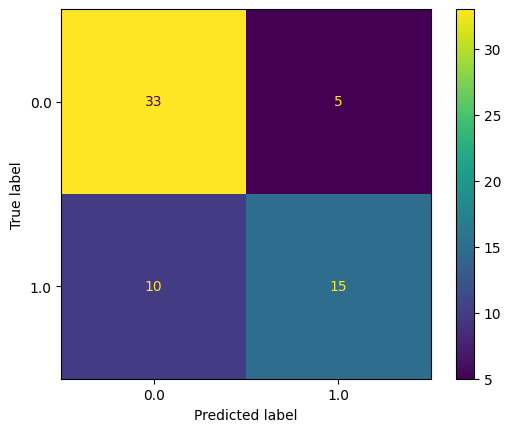

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['0.0','1.0'])
sns.reset_orig()
disp.plot()